In [1]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from IPython.display import display

import torch
from torch import nn

from torch.utils.data import DataLoader 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

In [2]:
# Getting Dataset
import zipfile
from pathlib import Path

data_file = Path("X_ray_DataSet")
file_name = "dataset"
data_file_path = data_file/file_name

if data_file_path.is_dir():
    print(f"{data_file_path} directory already exists.... skipping uploading")
else:
    print(f"{data_file_path} does not exist\nCreating one....")
    data_file_path.mkdir(parents=True, exist_ok=True)
    print(f"{data_file_path} successfully created and ready to store data/file")

X_ray_DataSet\dataset directory already exists.... skipping uploading
X_ray_DataSet\dataset successfully created and ready to store data/file


In [59]:
with zipfile.ZipFile(data_file_path/"x_ray.zip", "r") as zip_file:
    print("Unzipping pizza, x_ray data.....")
    zip_file.extractall(data_file_path)

Unzipping pizza, x_ray data.....


In [3]:
os.listdir(data_file_path/"chest_xray/test")

['NORMAL', 'PNEUMONIA']

In [4]:
train_dir = data_file_path/"chest_xray/train"
test_dir = data_file_path/"chest_xray/test"

In [5]:
data_files = data_file_path/"chest_xray"

os.listdir(data_files/"test/NORMAL")

['NORMAL-1049278-0001.jpeg',
 'NORMAL-1110860-0001.jpeg',
 'NORMAL-11419-0001.jpeg',
 'NORMAL-115218-0001.jpeg',
 'NORMAL-1160949-0001.jpeg',
 'NORMAL-1212407-0001.jpeg',
 'NORMAL-1228182-0001.jpeg',
 'NORMAL-1283091-0001.jpeg',
 'NORMAL-1318320-0001.jpeg',
 'NORMAL-1368583-0001.jpeg',
 'NORMAL-1430636-0001.jpeg',
 'NORMAL-1520670-0001.jpeg',
 'NORMAL-152130-0001.jpeg',
 'NORMAL-159472-0001.jpeg',
 'NORMAL-1608079-0001.jpeg',
 'NORMAL-1627110-0001.jpeg',
 'NORMAL-1698651-0001.jpeg',
 'NORMAL-171327-0001.jpeg',
 'NORMAL-1759114-0001.jpeg',
 'NORMAL-1763721-0001.jpeg',
 'NORMAL-1768815-0001.jpeg',
 'NORMAL-1771524-0001.jpeg',
 'NORMAL-1784004-0001.jpeg',
 'NORMAL-1803887-0001.jpeg',
 'NORMAL-1858497-0001.jpeg',
 'NORMAL-186900-0001.jpeg',
 'NORMAL-1931427-0001.jpeg',
 'NORMAL-1944537-0001.jpeg',
 'NORMAL-2107985-0001.jpeg',
 'NORMAL-2123652-0001.jpeg',
 'NORMAL-2162145-0001.jpeg',
 'NORMAL-217318-0001.jpeg',
 'NORMAL-2233350-0001.jpeg',
 'NORMAL-2256620-0001.jpeg',
 'NORMAL-2274324-0001.

In [6]:
image_paths = list(data_files.glob("*/*/*.jpeg"))

160 4613


(-0.5, 1415.5, 1127.5, -0.5)

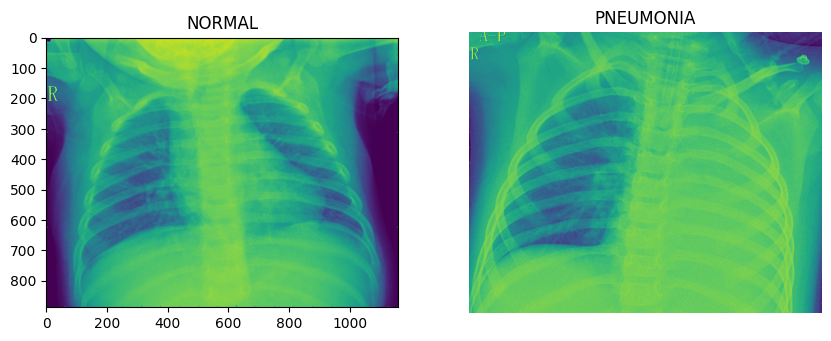

In [7]:
import random

idx = random.randint(0,  len(image_paths)-1)
idx2 = random.randint(0, len(image_paths)-1)
print(idx, idx2)

img1 = Image.open(image_paths[idx])
img2 = Image.open(image_paths[idx2])

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 7))

ax[0].imshow(img1)
ax[0].set_title(image_paths[idx].parent.stem)
plt.axis("off")

ax[1].imshow(img2)
ax[1].set_title(image_paths[idx2].parent.stem)
# plt.title(image_paths[idx2].parent.stem)
plt.axis("off")


In [8]:
os.listdir(data_files/"test")

['NORMAL', 'PNEUMONIA']

In [9]:
file_list_normal_train = os.listdir(data_files/"train"/"NORMAL")
file_list_pneu_train = os.listdir(data_files/"train"/"PNEUMONIA")

file_list_normal_test = os.listdir(data_files/"test"/"NORMAL")
file_list_pneu_test = os.listdir(data_files/"test"/"NORMAL")

print(f"there are {len(file_list_normal_train)} images for normal in train folder\n \
And also there are {len(file_list_pneu_train)} images for pneumonia inside train folder")


print(f"there are {len(file_list_normal_test)} images for normal in test folder\n \
And also there are {len(file_list_pneu_test)} images for pneumonia inside test folder")

there are 1349 images for normal in train folder
 And also there are 3883 images for pneumonia inside train folder
there are 234 images for normal in test folder
 And also there are 234 images for pneumonia inside test folder


In [10]:
idx = random.randint(0, len(file_list_normal_train)-1)
img = file_list_normal_train[idx]
# display(Image.open(img, 'r'), )
img = Image.open(img)
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'NORMAL-6478227-0001.jpeg'

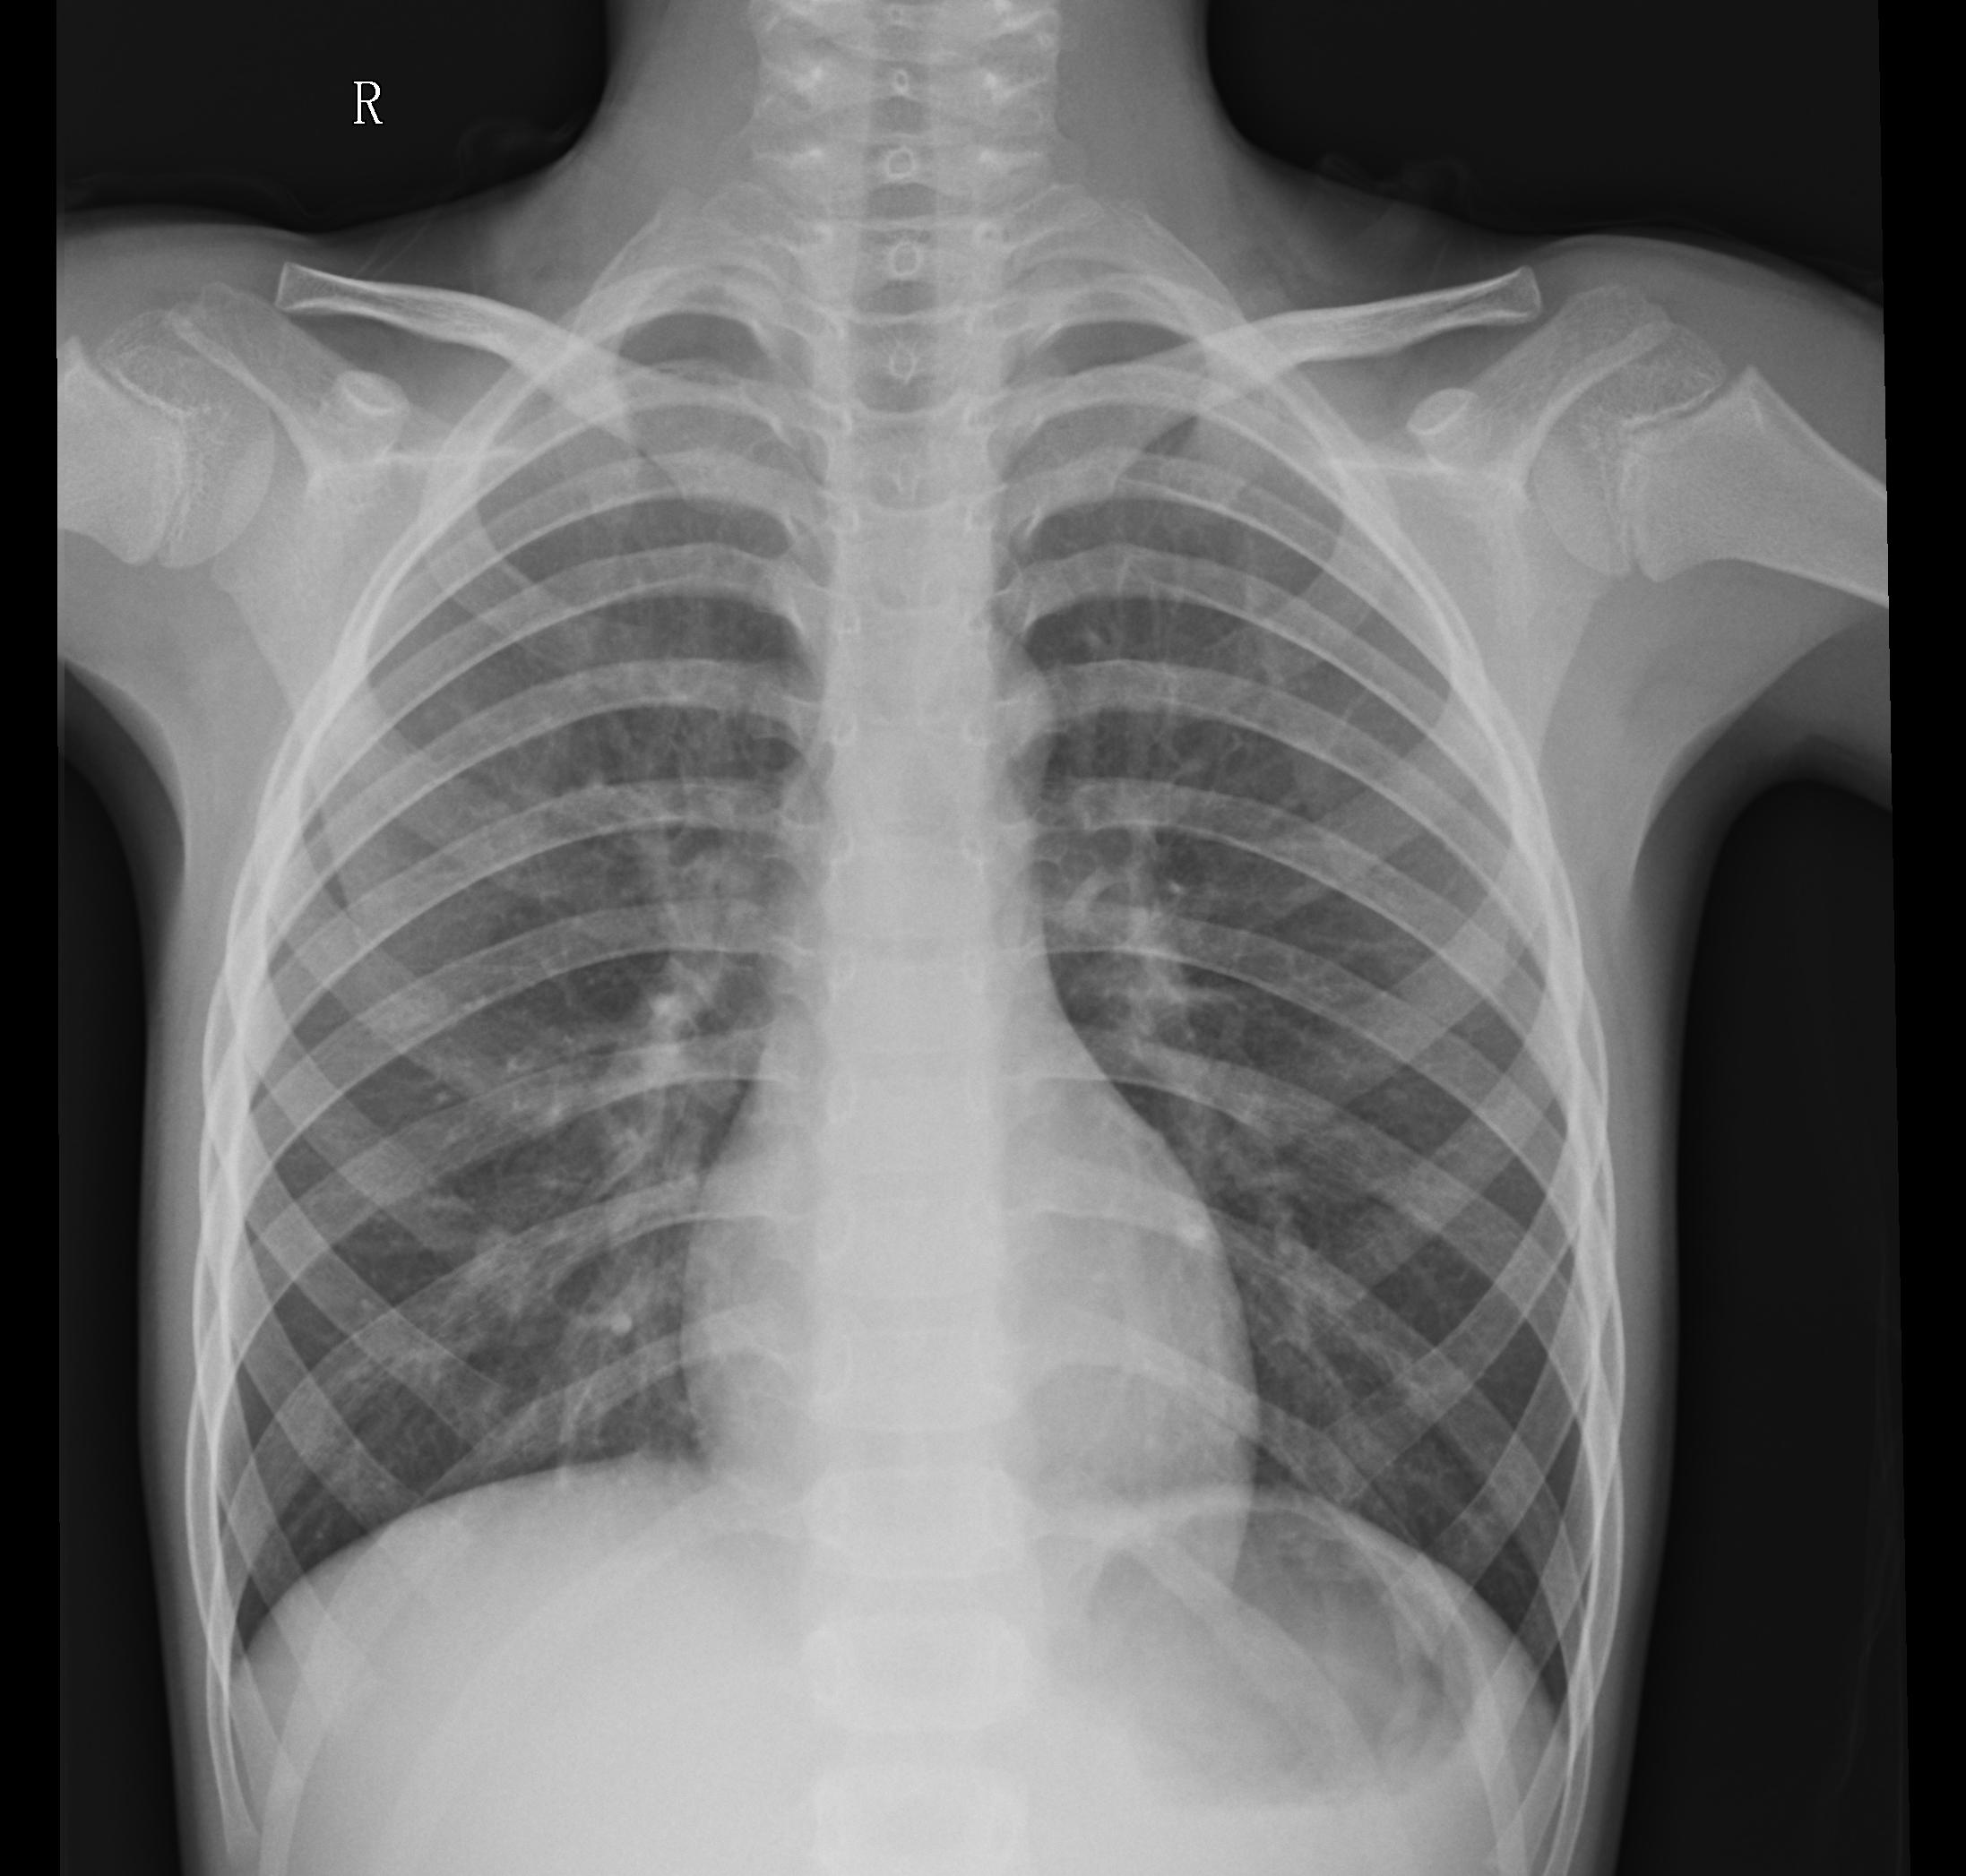

In [11]:
Image.open(image_paths[0])

In [12]:
type(file_list_normal_train[0])

str

In [13]:
mpimg.imread(image_paths[0]).shape

(2094, 2194)

AttributeError: 'WindowsPath' object has no attribute 'size'

In [14]:
train_dir

WindowsPath('X_ray_DataSet/dataset/chest_xray/train')

In [39]:
# Data Loader

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1,
                          saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

In [40]:
# Loading the image dat using torch.utils.datasets.ImageFolder

train_data = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

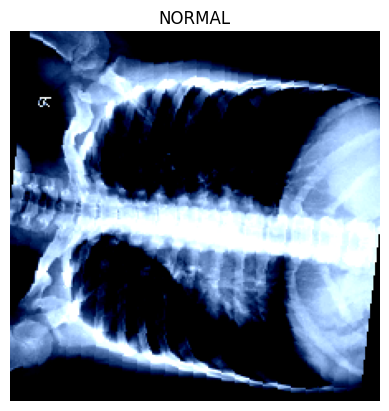

In [41]:
class_names = train_data.classes

image, label = train_data[0][0], train_data[0][1]

print(image.shape)
plt.imshow(image.permute(2, 1, 0))
plt.title(class_names[label])
plt.axis("off")

In [42]:
# Batchifying datasets

BATCH_SIZE = 16
train_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    dataset=train_data,
    batch_size=1,
    num_workers=1
)

In [43]:
print(f"Number of train images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")

Number of train images: 5232
Number of test images: 624


In [57]:
#Creating our Model

class Net(nn.Module):
    def __init__(self, input_shapes: int, output_shapes: int, hidden_units: int):
        super(Net, self).__init__()

        # Input Block
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shapes,
                out_channels=hidden_units,
                stride=1,
                padding=0,
                kernel_size=3,
                bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(8),
        )
            
        self.pool11 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units * 2,
                stride=1,
                padding=0,
                kernel_size=3,
                bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        
        self.pool22 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units *2,
                out_channels= hidden_units + 2,
                padding=0,
                stride=1,
                kernel_size=1,
                bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(10),
        )

        self.pool33 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units + 2,
                 out_channels = hidden_units + 2,
                 kernel_size = 3,
                 stride=1,
                 padding=0,
                 bias=False
                ), nn.ReLU(),
            nn.BatchNorm2d(10),
        )

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units + 2, out_channels=hidden_units * 4, kernel_size=1,
                padding=0, stride=1, bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.conv_block6 = nn.Sequential(
            nn.Conv2d(
                in_channels = hidden_units * 4,
                out_channels = hidden_units + 2, kernel_size=1,
                padding=0, stride=1, bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(10),
        )

        
        self.conv_block7 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units + 2, out_channels=hidden_units + 2,
                     kernel_size=3, padding=0, stride=1, bias=False), nn.ReLU(),
            nn.BatchNorm2d(10),
        )

        self.conv_block8 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units + 2,
                out_channels= hidden_units * 4,
                kernel_size = 1,
                stride=1,
                padding=0, bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(32),
        )
        self.conv_block9 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units * 4,
                out_channels= hidden_units + 2, stride=1,
                kernel_size = 1,
                padding=0, bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.conv_block10 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units + 2,
                out_channels= hidden_units + 6,
                stride=1,
                kernel_size = 3,
                padding=0, bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(14),
        )
        self.conv_block11 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units + 6,
                out_channels= hidden_units * 2,
                kernel_size = 3,
                stride=1,
                padding=0, bias=False
            ), nn.ReLU(),
            nn.BatchNorm2d(16),
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )

        self.conv_blockout = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units*2, out_channels=output_shapes, kernel_size=4,
                padding=0, bias=False
            ),
        )

    def forward(self, x):
        x = self.conv_block1(x)
        # print(f"Shape after block1: {x.shape}")
        x = self.pool11(x)
        # print(f"Shape after block1: {x.shape} pool11")
        x = self.conv_block2(x)
        # print(f"Shape after block2: {x.shape}")
        x = self.pool22(x)
        # print(f"Shape after block2: {x.shape} pool22")
        x = self.conv_block3(x)
        # print(f"Shape after block3: {x.shape}")
        x = self.pool33(x)
        # print(f"Shape after block3: {x.shape} pool33")
        x = self.conv_block4(x)
        # print(f"Shape after block4: {x.shape}")
        x = self.conv_block5(x)
        # print(f"Shape after block5: {x.shape}")
        x = self.conv_block6(x)
        # print(f"Shape after block6: {x.shape}")
        x = self.conv_block7(x)
        # print(f"Shape after block7: {x.shape}")
        x = self.conv_block8(x)
        # print(f"Shape after block8: {x.shape}")
        x = self.conv_block9(x)
        # print(f"Shape after block9: {x.shape}")
        x = self.conv_block10(x)
        # print(f"Shape after block10: {x.shape}")
        x = self.conv_block11(x)
        # print(f"Shape after block11: {x.shape}")
        x = self.gap(x)
        # print(f"Shape after gap: {x.shape}")
        x = self.conv_blockout(x)
        # print(f"Shape after blockout: {x.shape}")
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=1)
    

In [58]:
model_0 = Net(input_shapes = 3, output_shapes=2, hidden_units=8)

model_0

In [46]:
model_0.state_dict

<bound method Module.state_dict of Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (pool11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (pool22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block3): Sequential(
    (0): Conv2d(16, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (pool33): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block4): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (conv_block5): Sequential(
    (0): Conv2d(10, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
  )
  (conv_block6): Sequential(
    (0): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [47]:
rand_img = torch.randn(size=(3, 224, 224))

In [48]:
rand_img.shape

torch.Size([3, 224, 224])

In [49]:
pred_preds = model_0(rand_img)

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [51]:
model = model_0.to(device)

In [52]:
summary(model, input_size=image.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Conv2d-14           [-1, 10,

In [53]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, loss_fn, train_loader, optimizer, epoch, device):
    model.train()

    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch, (data, target) in enumerate(train_loader):
        # Getting data to the device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        
        y_pred = model(data)
        
        loss = loss_fn(y_pred, target)
        # print(f"The shape of y_pred: {y_pred.shape}") -> torch.Size([16, 2])
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc=f"Loss={loss.item()}| Batch_id={batch} | Accuracy: {(100 * correct/processed):.2f}")
        train_acc.append(100 * correct/processed)


def test(model, loss_fn, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.inference_mode():
        for  data, target in test_loader:
            data, target = data.to(device), target.to(device)
            test_pred = model(data)
            loss = loss_fn(test_pred, target)

            test_loss += loss.sum().item()
            pred = test_pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(f"\nTest set: Average loss: {test_loss:.4f} | Acc: {(100*correct/len(test_loader.dataset)):.2f}%")
    test_acc.append(100 * correct/len(test_loader.dataset))

In [54]:
model = model.to(device)

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
loss_fn = F.nll_loss

In [63]:
Epochs = 5

In [64]:
for epoch in range(Epochs):
    print(f"Epoch:{epoch}")
    train(model=model, device=device, loss_fn=loss_fn, optimizer=optimizer, train_loader=train_loader, epoch=epoch)
    scheduler.step()
    print(f"Current Learning Rate: {optimizer.state_dict()['param_groups'][0]['lr']}")
    test(
        model=model,
        device=device,
        test_loader=test_loader,
        loss_fn=loss_fn
    )

Epoch:0


Loss=0.6931390762329102| Batch_id=326 | Accuracy: 74.27:   0%| | 0/327 [


Current Learning Rate: 0.005

Test set: Average loss: 0.6931 | Acc: 74.20%
Epoch:1


Loss=0.693135678768158| Batch_id=326 | Accuracy: 74.22:   0%| | 0/327 [0


Current Learning Rate: 0.005

Test set: Average loss: 0.6931 | Acc: 74.22%
Epoch:2


Loss=0.6931284666061401| Batch_id=326 | Accuracy: 74.22:   0%| | 0/327 [


Current Learning Rate: 0.005

Test set: Average loss: 0.6931 | Acc: 74.22%
Epoch:3


Loss=0.6931292414665222| Batch_id=326 | Accuracy: 74.22:   0%| | 0/327 [


Current Learning Rate: 0.0025

Test set: Average loss: 0.6931 | Acc: 74.22%
Epoch:4


Loss=0.6931286454200745| Batch_id=326 | Accuracy: 74.22:   0%| | 0/327 [


Current Learning Rate: 0.0025

Test set: Average loss: 0.6931 | Acc: 74.22%


In [59]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]

Text(0.5, 1.0, 'Test accuracy')

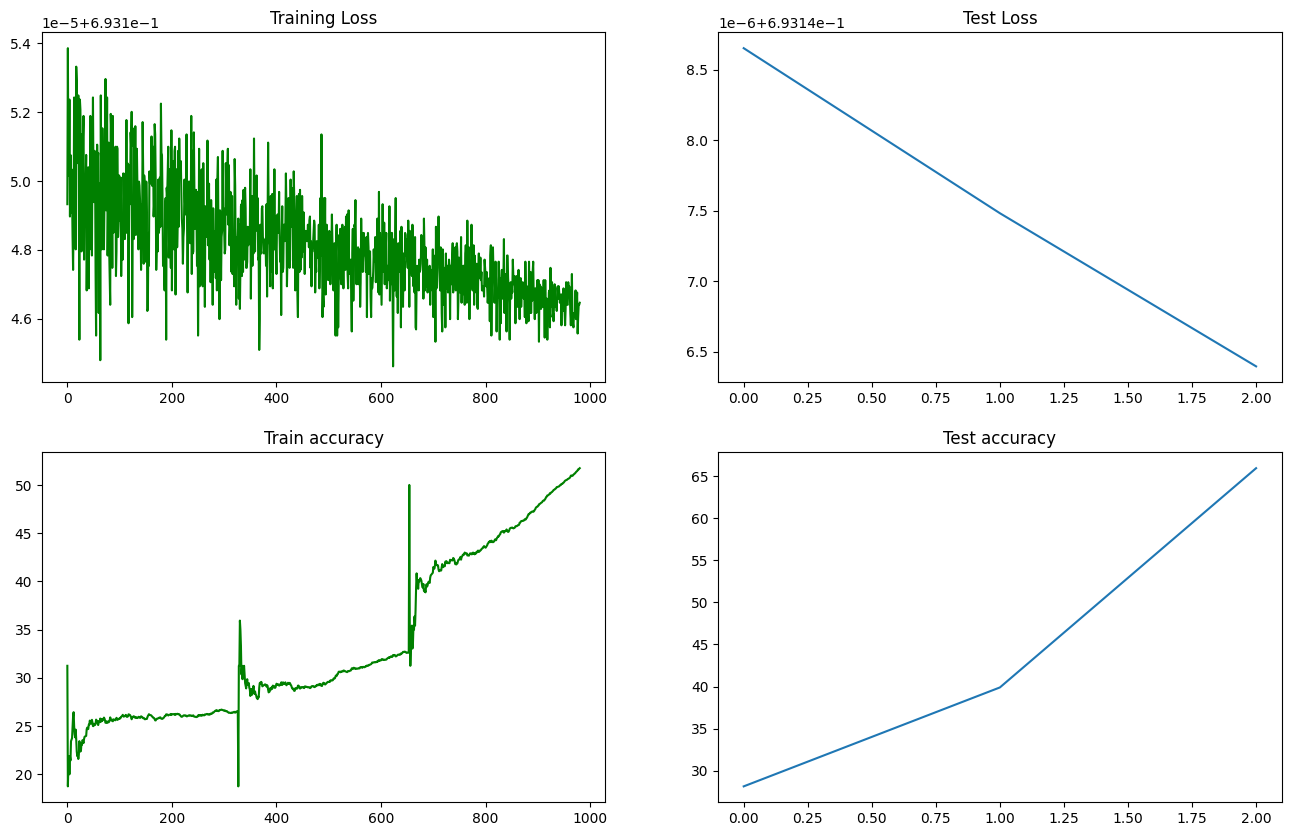

In [60]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 10))
ax[0, 0].plot(train_losses1, color='green')
ax[0, 0].set_title('Training Loss')
ax[1, 0].plot(train_acc1, color='green')
ax[1, 0].set_title("Train accuracy")
ax[0, 1].plot(test_losses1)
ax[0, 1].set_title("Test Loss")
ax[1, 1].plot(test_acc1)
ax[1, 1].set_title("Test accuracy")

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(),
    transform.CenterCrop(),
    transform.Colorjitter(brightness=0.10, contrast=0.1, hue=0.1, saturation=0.10),
    transforms.RandomHorizontalFlip(),
    transforms.RadomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.225], [0.229, 0.224, 0.225])
])